Import Block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Data Exploratory


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-beras-malang-2017-2021.csv?token=ARB4LTFRC4SA5X2NEYIS3JDAXYZOC \
    -O /tmp/rice.csv

--2021-05-31 15:02:39--  https://raw.githubusercontent.com/christiandoxa/usahaq_ml/master/Dataset/Dataset%20Bahan%20Pokok/daftar-harga-beras-malang-2017-2021.csv?token=ARB4LTFRC4SA5X2NEYIS3JDAXYZOC
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15774 (15K) [text/plain]
Saving to: ‘/tmp/rice.csv’

/tmp/rice.csv       100%[===================>]  15.40K  --.-KB/s    in 0s      

2021-05-31 15:02:39 (80.6 MB/s) - ‘/tmp/rice.csv’ saved [15774/15774]



In [3]:
#Read dataset with pandas, then put it to rice_df variable
rice_df = pd.read_csv('/tmp/rice.csv')
rice_df

tanggal  harga
0    2017-08-02   9200
1    2017-08-03   9200
2    2017-08-04   9200
3    2017-08-07   9200
4    2017-08-08   9200
..          ...    ...
935  2021-05-24  10000
936  2021-05-25  10000
937  2021-05-27  10000
938  2021-05-28  10000
939  2021-05-31  10000

[940 rows x 2 columns]

In [4]:
#Inspect the first 5 of rice_df dataframe
rice_df.head()

tanggal  harga
0  2017-08-02   9200
1  2017-08-03   9200
2  2017-08-04   9200
3  2017-08-07   9200
4  2017-08-08   9200

In [5]:
#Inspect the last 5 of rice_df dataframe
rice_df.tail()

tanggal  harga
935  2021-05-24  10000
936  2021-05-25  10000
937  2021-05-27  10000
938  2021-05-28  10000
939  2021-05-31  10000

In [6]:
#Inspect the describtion of rice_df dataframe
rice_df.describe()

harga
count    940.000000
mean   10228.351064
std      479.685227
min     9200.000000
25%    10000.000000
50%    10200.000000
75%    10500.000000
max    11600.000000

In [7]:
#Casting harga's column to float
rice_df['harga'] = pd.to_numeric(rice_df['harga'], downcast='float')
print(rice_df)
print(rice_df.dtypes)

        tanggal    harga
0    2017-08-02   9200.0
1    2017-08-03   9200.0
2    2017-08-04   9200.0
3    2017-08-07   9200.0
4    2017-08-08   9200.0
..          ...      ...
935  2021-05-24  10000.0
936  2021-05-25  10000.0
937  2021-05-27  10000.0
938  2021-05-28  10000.0
939  2021-05-31  10000.0

[940 rows x 2 columns]
tanggal     object
harga      float32
dtype: object


In [8]:
#Normalize harga's column data by dividing it with the largest number
max = rice_df['harga'].max()
rice_df['harga'] /= max

In [9]:
rice_df

tanggal     harga
0    2017-08-02  0.793103
1    2017-08-03  0.793103
2    2017-08-04  0.793103
3    2017-08-07  0.793103
4    2017-08-08  0.793103
..          ...       ...
935  2021-05-24  0.862069
936  2021-05-25  0.862069
937  2021-05-27  0.862069
938  2021-05-28  0.862069
939  2021-05-31  0.862069

[940 rows x 2 columns]

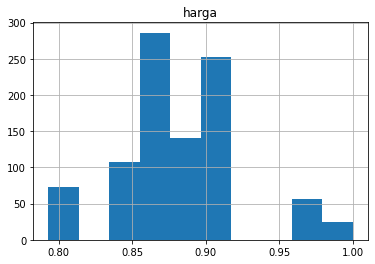

In [10]:
_ = rice_df.hist()

In [11]:
#Get the price and time step from dataframe
temp = rice_df['harga']
price = np.array(temp.tolist())
time = np.array([i[0] for i in enumerate(price)])

In [12]:
#Helper function for plotting dataset
def plot_dataset(time, series, title, xlabel, ylabel, color='b'):
  plt.plot(time, series, '{}-'.format(color))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid=True

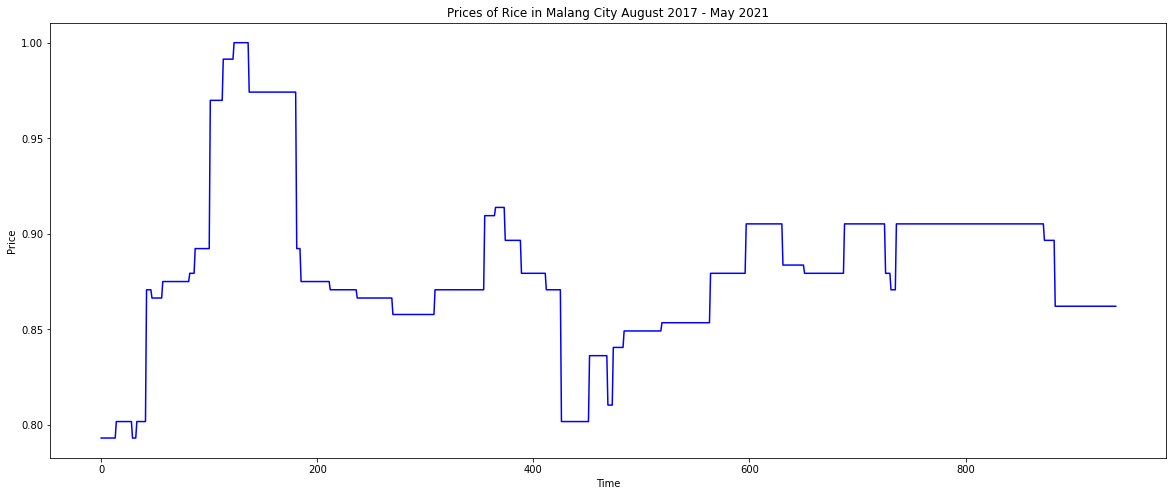

In [13]:
#Plot the dataset
plt.figure(figsize=(20, 8))
plot_dataset(time=time, series=price, color='b', title='Prices of Rice in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

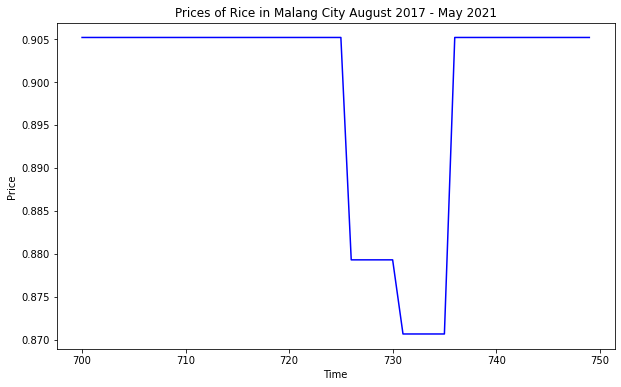

In [14]:
plt.figure(figsize=(10, 6))
plot_dataset(time=time[700:750], series=price[700:750], color='b', title='Prices of Rice in Malang City August 2017 - May 2021', xlabel='Time', ylabel='Price')

Split Train and Test

In [15]:
#Split dataset with 70% of training, 20% for validation, and the rest for testing
split = round(0.7*len(price))
split_val = round(0.9*len(price))
train_price = price[:split]
train_time = time[:split]
val_price = price[split:split_val]
val_time = time[split:split_val]
test_price = price[split_val:]
test_time = time[split_val:]

Window the Dataset 

In [16]:
#Helper function for windowing the dataset
def dataset_window(list, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(temp, axis=-1)
  data_window = tf.data.Dataset.from_tensor_slices(series)
  data_window = data_window.window(window_size + 1, shift = 1, drop_remainder= True)
  data_window = data_window.flat_map(lambda x: x.batch(window_size+1))
  data_window = data_window.shuffle(shuffle_buffer)
  data_window = data_window.map(lambda x: (x[:-1], x[1:]))
  data_window = data_window.batch(batch_size).prefetch(1)
  return data_window

Function for Forecasting the Model for Fit It Into the Plotted Graph

In [17]:
#Helper function for forecasting
def forecast_model(model, series, window_size):
  data_forecast = tf.data.Dataset.from_tensor_slices(series)
  data_forecast = data_forecast.window(window_size, shift=1, drop_remainder=True)
  data_forecast = data_forecast.flat_map(lambda x: x.batch(window_size))
  data_forecast = data_forecast.batch(32).prefetch(1)
  print(data_forecast)
  forecast = model.predict(data_forecast)
  return forecast

Window Size, Batch Size, & Shuffle Buffer

In [18]:
window_size = 50
batch_size = 512
shuffle_buffer = 1000

Build the Model

In [19]:
#Building model with learning rate scheduler, so we can pick the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)

print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-8 * 10**(x/20))
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=200, callbacks=[learning_rate_scheduler])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/200
2/2 [==============================] - 34s 86ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 2/200
2/2 [==============================] - 0s 16ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 3/200
2/2 [==============================] - 0s 14ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 5/200
2/2 [==============================] - 0s 14ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 6/200
2/2 [==============================] - 0s 14ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 7/200
2/2 [==============================] - 0s 14ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 8/200
2/2 [==============================] - 0s 16ms/step - loss: 0.4695 - mean_absolute_error: 0.9679
Epoch 9/200
2/2 [=========

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 16)          272       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 11,937
Trainable params: 11,937
Non-trainable params: 0
_________________________________________________________________


(0.01, 0.1, 0.0, 0.2)

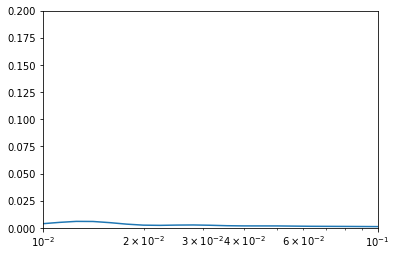

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-2, 1e-1, 0, 0.2])

In [26]:
#Build the final model with the best learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = dataset_window(train_price, window_size, batch_size, shuffle_buffer)
val_set = dataset_window(val_price, window_size, batch_size, shuffle_buffer)
print(train_set)
print(train_price.shape)

model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                                 padding='causal', activation='relu',
                                 input_shape=[None,1]),
          tf.keras.layers.LSTM(32, return_sequences=True),
          tf.keras.layers.LSTM(16, return_sequences=True),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.8),
              metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_set, epochs=150, validation_data=val_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(658,)
Epoch 1/150
2/2 [==============================] - 3s 753ms/step - loss: 0.2722 - mean_absolute_error: 0.7196 - val_loss: 0.0105 - val_mean_absolute_error: 0.0789
Epoch 2/150
2/2 [==============================] - 0s 144ms/step - loss: 0.0319 - mean_absolute_error: 0.1875 - val_loss: 0.0848 - val_mean_absolute_error: 0.3951
Epoch 3/150
2/2 [==============================] - 0s 142ms/step - loss: 0.0608 - mean_absolute_error: 0.3240 - val_loss: 0.0040 - val_mean_absolute_error: 0.0607
Epoch 4/150
2/2 [==============================] - 0s 142ms/step - loss: 0.0080 - mean_absolute_error: 0.0985 - val_loss: 0.0246 - val_mean_absolute_error: 0.2147
Epoch 5/150
2/2 [==============================] - 0s 150ms/step - loss: 0.0229 - mean_absolute_error: 0.2067 - val_loss: 0.0088 - val_mean_absolute_error: 0.1204
Epoch 6/150
2/2 [==============================] - 0s 136ms/step - loss: 0.0060 - me

In [27]:
#Forecasting the testing data
rnn_forecast = forecast_model(model, price[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_val - window_size:-1, -1, 0]

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


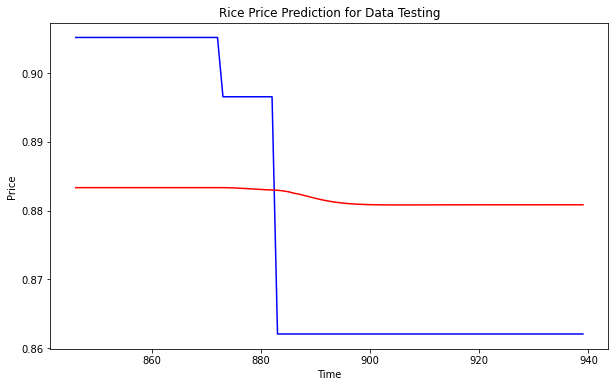

In [28]:
#Plotting the testing data
plt.figure(figsize=(10, 6))
plot_dataset(time=test_time, series=test_price, title='Rice Price Prediction for Data Testing',xlabel='Time', ylabel='Price')
plot_dataset(time=test_time, series=rnn_forecast, title='Rice Price Prediction for Data Testing', xlabel='Time', ylabel='Price', color='r')

<Figure size 432x288 with 0 Axes>

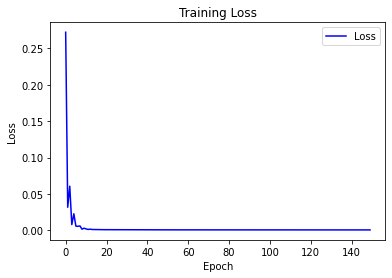

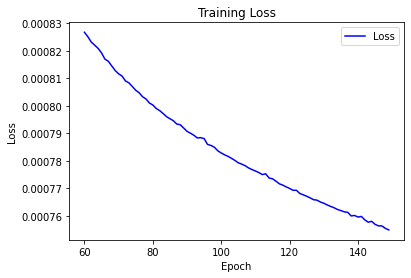

<Figure size 432x288 with 0 Axes>

In [30]:
#Plotting and examining the training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']

epoch_num=range(len(loss))

plot_dataset(epoch_num, loss, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

loss_zoom = loss[60:]
epoch_num_zoom = [x+60 for x in range(len(loss_zoom))]

plot_dataset(epoch_num_zoom, loss_zoom, title='Training Loss', xlabel='Epoch', ylabel='Loss')
plt.legend(["Loss"])
plt.figure()

In [31]:
rnn_forecast

array([0.88334215, 0.88334215, 0.88334215, 0.88334215, 0.88334215,
       0.88334215, 0.88334215, 0.88334215, 0.88334215, 0.88334215,
       0.88334215, 0.88334215, 0.88334215, 0.88334215, 0.88334215,
       0.88334215, 0.88334215, 0.88334215, 0.88334215, 0.88334215,
       0.88334215, 0.88334215, 0.88334215, 0.88334215, 0.88334215,
       0.88334215, 0.88334215, 0.88334215, 0.8833269 , 0.8833008 ,
       0.88325316, 0.88321936, 0.88317263, 0.883124  , 0.88307625,
       0.8830321 , 0.88299316, 0.8829597 , 0.8828708 , 0.88274324,
       0.8825339 , 0.8823832 , 0.88218397, 0.88197935, 0.88178045,
       0.8815976 , 0.8814367 , 0.8812996 , 0.8811858 , 0.88109374,
       0.88102067, 0.8809641 , 0.8809212 , 0.8808894 , 0.8808665 ,
       0.8808507 , 0.8808402 , 0.8808336 , 0.88083   , 0.8808285 ,
       0.8808284 , 0.8808292 , 0.8808307 , 0.8808325 , 0.88083434,
       0.88083625, 0.88083816, 0.8808398 , 0.8808414 , 0.8808428 ,
       0.880844  , 0.8808452 , 0.88084614, 0.8808469 , 0.88084

In [32]:
temp = len(test_price)-21
temp_1 = len(test_price)-1
temp=test_price[temp:temp_1]

In [33]:
rnn_forecast = forecast_model(model, temp[..., np.newaxis],len(temp)).tolist()
rnn_forecast

<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


[[[0.8388159871101379],
  [0.864897608757019],
  [0.8814371824264526],
  [0.889520525932312],
  [0.8934981822967529],
  [0.8943807482719421],
  [0.8932249546051025],
  [0.8909869194030762],
  [0.8896609544754028],
  [0.8895758390426636],
  [0.889161229133606],
  [0.8885712623596191],
  [0.8879029154777527],
  [0.8872156739234924],
  [0.8865442872047424],
  [0.8859080672264099],
  [0.8853168487548828],
  [0.8847749829292297],
  [0.884283185005188],
  [0.8838402628898621]]]

In [34]:
round(rnn_forecast[-1][-1][0]*max)

10253

In [35]:
model.save("rice_model")

INFO:tensorflow:Assets written to: rice_model/assets


INFO:tensorflow:Assets written to: rice_model/assets


In [36]:
!zip -r rice_model.zip rice_model

  adding: rice_model/ (stored 0%)
  adding: rice_model/assets/ (stored 0%)
  adding: rice_model/keras_metadata.pb (deflated 91%)
  adding: rice_model/saved_model.pb (deflated 89%)
  adding: rice_model/variables/ (stored 0%)
  adding: rice_model/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: rice_model/variables/variables.index (deflated 66%)
